In [213]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, log_loss
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from functools import partial
import optuna

In [69]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')

for df in [train_df, test_df]:
    df[df == 'None'] = np.nan
    df.loc[df['rectal_exam_feces'] == 'serosanguious', 'rectal_exam_feces'] = np.nan
    df.loc[df['peristalsis'] == 'distend_small', 'peristalsis'] = np.nan
    df.loc[df['nasogastric_reflux'] == 'slight', 'nasogastric_reflux'] = 'less_1_liter'

train_df[train_df == 'None'] = np.nan
test_df[test_df == 'None'] = np.nan

num_features = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', ]
cat_features = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'lesion_1', 'lesion_2', 'lesion_3', ]
no_idea = ['hospital_number']

# Data Description

In [4]:
train_df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


## Shape and Columns

In [35]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
print('Test Descriptors')
print(f'Shape: {test_df.shape}')
print(test_df.columns)

Train Descriptors
Shape: (1235, 28)
Columns : Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome'],
      dtype='object')

Test Descriptors
Shape: (824, 27)
Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_vo

## Missing Values

In [36]:
null_values = {'column': [], 'train_null_values': [], 'test_null_values': []}

for col in test_df.columns:
    train_col_null = train_df[col].isna().sum()
    test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    null_values['test_null_values'].append(test_col_null)
    
null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values.style.format({'train_null_perc': '{:.0%}',
                          'test_null_perc': '{:.0%}'})


,column,train_null_values,test_null_values,train_total,test_total,train_null_perc,test_null_perc
17,abdomen,213,154,1235,824,17%,19%
16,rectal_exam_feces,190,125,1235,824,15%,15%
13,nasogastric_tube,80,64,1235,824,6%,8%
7,peripheral_pulse,60,47,1235,824,5%,6%
20,abdomo_appearance,48,31,1235,824,4%,4%
10,pain,44,29,1235,824,4%,4%
6,temp_of_extremities,39,35,1235,824,3%,4%
12,abdominal_distention,23,22,1235,824,2%,3%
8,mucous_membrane,21,13,1235,824,2%,2%
14,nasogastric_reflux,21,14,1235,824,2%,2%


In [43]:
null_values_per_row = train_df.isna().sum(axis=1)
pd.DataFrame(null_values_per_row.value_counts().sort_index())

,0
0,770
1,291
2,116
3,32
4,10
5,8
6,1
7,1
8,1
9,3


In [168]:
missing_values = {'column': [], 'only_in_train': [], 'only_in_test': []}

for col in ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data',]:
    train_col_unique = train_df[col].unique()
    test_col_unique = test_df[col].unique()
    
    missing_values['column'].append(col)
    missing_values['only_in_train'].append([f for f in train_col_unique if f not in test_col_unique])
    missing_values['only_in_test'].append([f for f in test_col_unique if f not in train_col_unique])

missing_values = pd.DataFrame(missing_values)
missing_values

,column,only_in_train,only_in_test
0,surgery,[],[]
1,age,[],[]
2,temp_of_extremities,[],[]
3,peripheral_pulse,[],[]
4,mucous_membrane,[],[]
5,capillary_refill_time,[],[]
6,pain,[slight],[moderate]
7,peristalsis,[distend_small],[]
8,abdominal_distention,[],[]
9,nasogastric_tube,[],[]


# Exploratory Data Analysis

In [3]:
df = train_df.copy()

## Variable Distribution

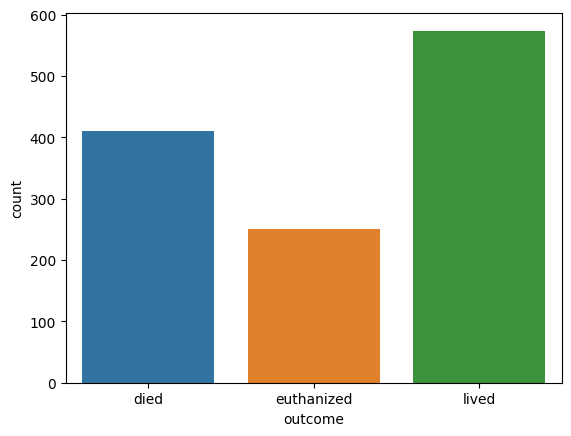

In [19]:
sns.countplot(data=df, x='outcome')
plt.show()

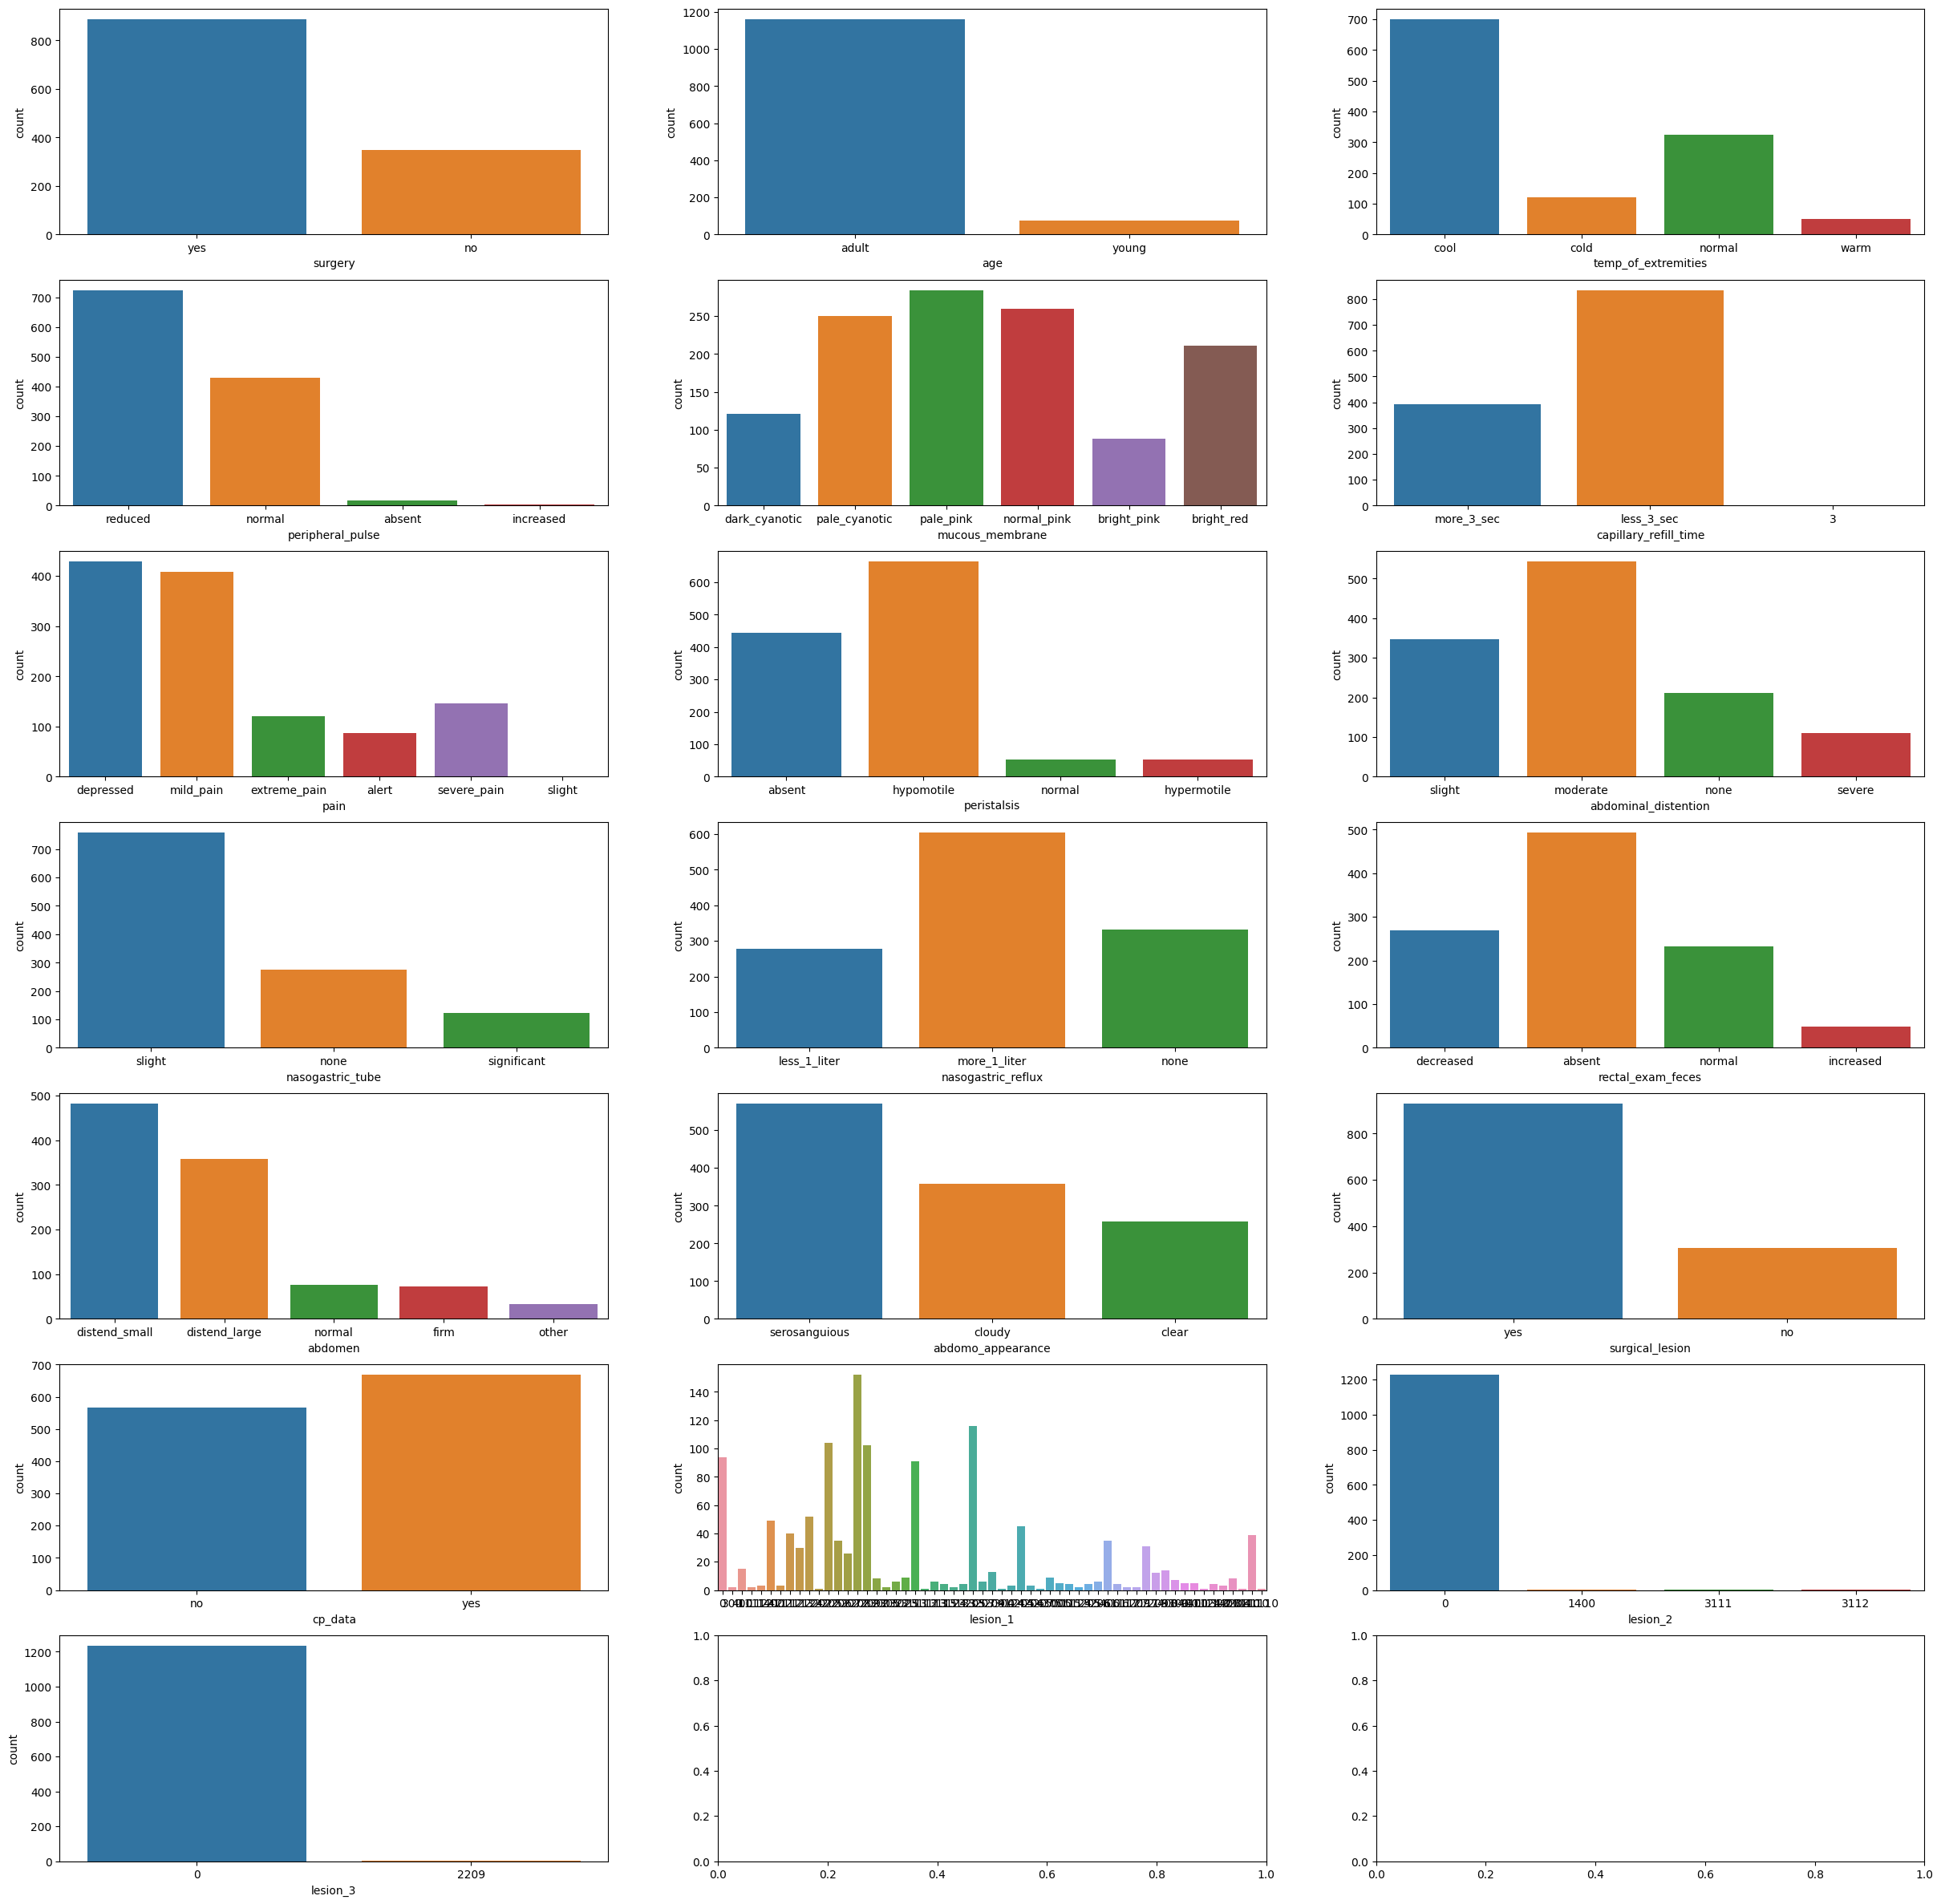

In [20]:
fig, axs = plt.subplots(nrows=len(cat_features)//3 + 1, ncols=3, figsize=(30,30))
axs = axs.flatten()

for i, feat in enumerate(cat_features):
    sns.countplot(data=df, x=feat, ax=axs[i])
plt.show()

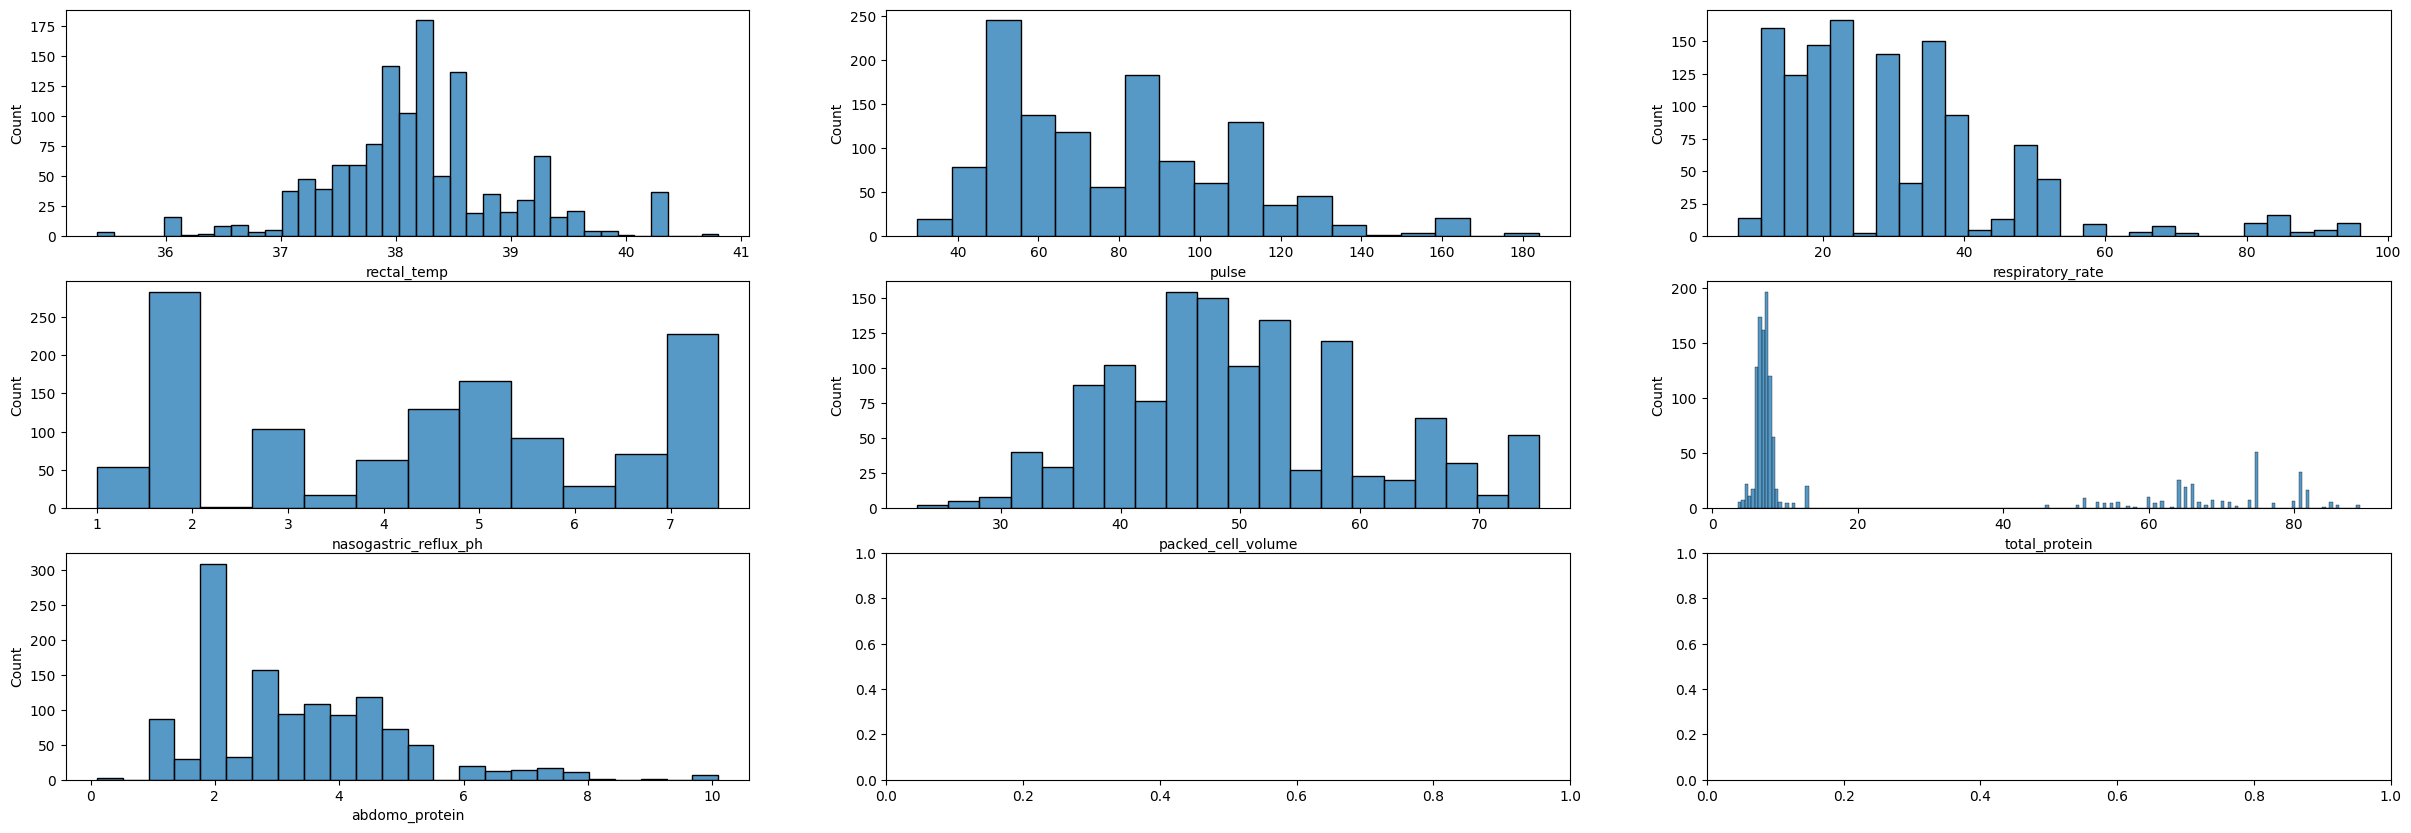

In [23]:
fig, axs = plt.subplots(nrows=len(num_features)//3 + 1, ncols=3, figsize=(30,10))
axs = axs.flatten()

for i, feat in enumerate(num_features):
    sns.histplot(data=df, x=feat, ax=axs[i])
plt.show()

## Rectal Temperature

https://www.kaggle.com/competitions/playground-series-s3e22/discussion/438680

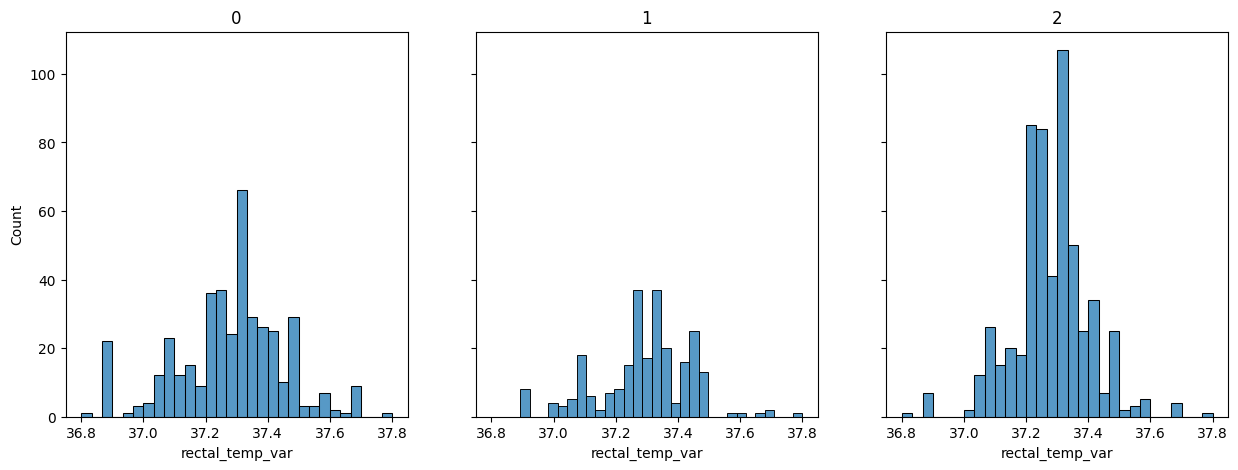

In [67]:
normal_rectal_temp = 37.8
df['rectal_temp_var'] = (df['rectal_temp'] - normal_rectal_temp).abs()

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
for i, oc in enumerate(df['outcome'].unique()):
    sns.histplot(data=df[df['outcome'] == oc], x='rectal_temp_var', bins=30, ax=axs[i])
    axs[i].title.set_text(oc)
plt.show()

## Numerical Transformations

In [82]:
df = train_df.copy()

# Add Rectal Temp Variation
normal_rectal_temp = 37.8
df['rectal_temp_var'] = (df['rectal_temp'] - normal_rectal_temp).abs()

num_features = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'rectal_temp_var']
df = df[num_features + ['outcome']]

mms = MinMaxScaler()
for feat in num_features:
    df[feat] = mms.fit_transform(df[feat].values.reshape(-1,1))

best_features = pd.DataFrame()

for i in tqdm(range(len(num_features)), desc='Features'):
    feat = num_features[i]
    trans_feat_f1_score = pd.DataFrame()
    
    # Log
    df[feat + '_log'] = np.log1p(df[feat])
    
    # Square Root
    df[feat + '_sqrt'] = np.sqrt(df[feat])
    
    # Box Cox
    epsl = 1e-5
    transformer = PowerTransformer(method='box-cox')
    df[feat + '_boxcox'] = transformer.fit_transform((df[[feat]] + epsl))
    
    # Yeo Johnson
    transformer = PowerTransformer(method='yeo-johnson')
    df[feat + '_yeojohn'] = transformer.fit_transform(df[[feat]])
    
    # Power Transform (0.25)
    df[feat + '_power0.25'] = np.power(df[feat], 0.25)
    
    # Power Transform (2)
    df[feat + '_power2'] = np.power(df[feat], 2)
    
    # Log Power Transform
    df[feat + '_log_power'] = np.log1p(df[feat + '_sqrt'])
    
    trans_feat = [f for f in df.columns if feat in f]
    df[trans_feat] = df[trans_feat].fillna(0)
    
    pca = TruncatedSVD(n_components=1)
    pca_df = pd.DataFrame(pca.fit_transform(df[trans_feat]), columns=[feat + '_pca'])
    
    df = pd.concat([df, pca_df], axis=1)
    trans_feat.append(feat + '_pca')
    
    target_le = LabelEncoder()
    df['outcome'] = target_le.fit_transform(df['outcome'])
    
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
    col_f1 = []
    
    for col in trans_feat:
        X_col = df[col]
        y_col = df['outcome']
        oof_f1 = []
        
        for fold, (train_idx, test_idx) in enumerate(k_fold.split(X_col, y_col)):
            X_train, X_valid = X_col.iloc[train_idx], X_col.iloc[test_idx]
            y_train, y_valid = y_col.iloc[train_idx], y_col.iloc[test_idx]
            
            model = SVC(
                gamma='auto',
                probability=True,
                random_state=42
            )
            
            model.fit(X_train.values.reshape(-1, 1), y_train)
            
            oof_preds = model.predict(X_valid.values.reshape(-1, 1))
            oof_f1.append(f1_score(y_valid, oof_preds, average='micro'))
        col_f1.append(np.mean(oof_f1))
        
    trans_feat_f1_score = pd.concat([trans_feat_f1_score, pd.DataFrame({'feature': feat, 'transformed': trans_feat, 'trans_f1_score': col_f1})])
    best_trans_feat = trans_feat_f1_score.max()
    best_features = pd.concat([best_features, pd.DataFrame({
        'feature': feat, 
        'best_trans_feat': best_trans_feat['transformed'], 
        'orig_f1_score': trans_feat_f1_score[trans_feat_f1_score['transformed'] == feat]['trans_f1_score'],
        'trans_f1_score': best_trans_feat['trans_f1_score']
    })])

Features:   0%|          | 0/8 [00:00<?, ?it/s]

In [83]:
best_features

,feature,best_trans_feat,orig_f1_score,trans_f1_score
0,rectal_temp,rectal_temp_yeojohn,0.466397,0.489069
0,pulse,pulse_yeojohn,0.548988,0.553846
0,respiratory_rate,respiratory_rate_yeojohn,0.472065,0.486640
0,nasogastric_reflux_ph,nasogastric_reflux_ph_yeojohn,0.461538,0.527126
0,packed_cell_volume,packed_cell_volume_yeojohn,0.481781,0.511741
0,total_protein,total_protein_yeojohn,0.481781,0.493927
0,abdomo_protein,abdomo_protein_yeojohn,0.464777,0.475304
0,rectal_temp_var,rectal_temp_var_yeojohn,0.482591,0.482591


In [ ]:
for feat in num_features:
    fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(30,3))
    sns.histplot(data=df, x=feat, ax=axs[0])
    
    for i, trans in enumerate(['_log', '_sqrt', '_boxcox', '_yeojohn', '_power0.25', '_power2', '_log_power']):
        sns.histplot(data=df, x=feat+trans, ax=axs[i+1])

plt.show()

## Hospital

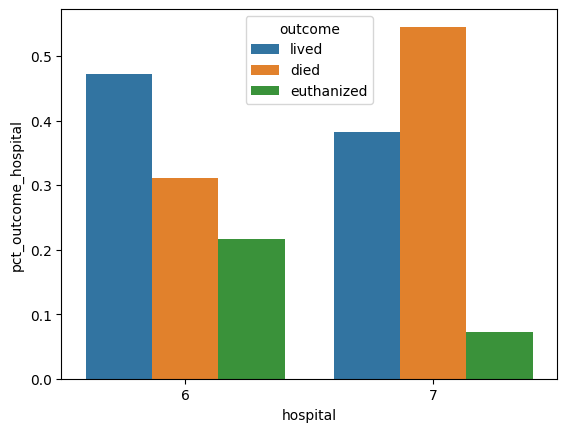

In [24]:
df['hospital'] = df['hospital_number'].astype(str).apply(lambda x: len(x))

hospital_outcome = pd.merge(
    df.groupby('hospital').value_counts(['outcome']).reset_index(), 
    df.groupby('hospital').size().reset_index(), 
    on='hospital'
).rename(columns={'count': 'outcome_count', 0: 'hospital_count'})
hospital_outcome['pct_outcome_hospital'] = hospital_outcome['outcome_count'] / hospital_outcome['hospital_count']

sns.barplot(
    data=hospital_outcome,
    x='hospital',
    y='pct_outcome_hospital',
    hue='outcome'
)
plt.show()

## Lesions

In [133]:
def clean_lesion_num(x):
    if len(x) == 2:
        return x * 100
    elif len(x) == 3:
        return x * 10
    else:
        return x

def decode_lesion(x):
    if x != '0':
        if len(x) == 5 and int(x[3:]) != 10:
            return map(int, [x[:2], x[2], x[3], x[4]])
        elif len(x) == 5:
            return map(int, [x[0], x[1], x[2], x[3:]])
        else:
            return map(int, [x[0], x[1], x[2], x[3]])
    else:
        return map(int, [-1, -1, -1, -1])

lesion_site_map = {
    1: "Gastric",
    2: "Small_Intestine",
    3: "Large_Colon",
    4: "Large_Colon_and_Cecum",
    5: "Cecum",
    6: "Transverse_Colon",
    7: "Rectum_Descending_Colon",
    8: "Uterus",
    9: "Bladder",
    11: "All_Intestinal_Sites",
    12: "Site_Other",
    -1: None
}

lesion_type_map = {
    1: "Simple",
    2: "Strangulation",
    3: "Inflammation",
    4: "Type_Other",
    7: "Type_Other",
    0: None,
    -1: None
    
}
lesion_subtype_map = {
    1: "Mechanical",
    2: "Paralytic",
    3: "Subtype_Other",
    0: None,
    -1: None
}

lesion_code_map = {
    1: "Obturation",
    2: "Intrinsic",
    3: "Extrinsic",
    4: "Adynamic",
    5: "Volvulus_Torsion",
    6: "Intussusception",
    7: "Thromboembolic",
    8: "Hernia",
    9: "Lipoma_Splenic_Incarceration",
    10: "Displacement",
    0: None,
    -1: None
}

In [145]:
temp = df.copy()
temp['lesion_1_breakdown'] = temp['lesion_1'].astype(str).apply(clean_lesion_num).apply(decode_lesion)
temp['has_lesion_1'] = temp['lesion_1'] != 0
lesion_1_breakdown = pd.DataFrame(temp['lesion_1_breakdown'].tolist(), columns=['lesion_1_site', 'lesion_1_type', 'lesion_1_subtype', 'lesion_1_code'])
lesion_1_breakdown['lesion_1_site'] = lesion_1_breakdown['lesion_1_site'].replace(lesion_site_map)
lesion_1_breakdown['lesion_1_type'] = lesion_1_breakdown['lesion_1_type'].replace(lesion_type_map)
lesion_1_breakdown['lesion_1_subtype'] = lesion_1_breakdown['lesion_1_subtype'].replace(lesion_subtype_map)
lesion_1_breakdown['lesion_1_code'] = lesion_1_breakdown['lesion_1_code'].replace(lesion_code_map)
temp = pd.concat([temp, lesion_1_breakdown], axis=1).drop(columns='lesion_1_breakdown')

temp.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,lesion_1,lesion_2,lesion_3,cp_data,outcome,has_lesion_1,lesion_1_site,lesion_1_type,lesion_1_subtype,lesion_1_code
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,2209,0,0,no,died,True,Small_Intestine,Strangulation,None,Lipoma_Splenic_Incarceration
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,2208,0,0,no,euthanized,True,Small_Intestine,Strangulation,None,Hernia
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,5124,0,0,no,lived,True,Cecum,Simple,Paralytic,Adynamic
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,2208,0,0,yes,lived,True,Small_Intestine,Strangulation,None,Hernia
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,0,0,0,yes,lived,False,None,None,None,None


In [146]:
temp = df.copy()
temp['lesion_2_breakdown'] = temp['lesion_2'].astype(str).apply(clean_lesion_num).apply(decode_lesion)
temp['has_lesion_2'] = temp['lesion_2'] != 0
lesion_2_breakdown = pd.DataFrame(temp['lesion_2_breakdown'].tolist(), columns=['lesion_2_site', 'lesion_2_type', 'lesion_2_subtype', 'lesion_2_code'])
lesion_2_breakdown['lesion_2_site'] = lesion_2_breakdown['lesion_2_site'].replace(lesion_site_map)
lesion_2_breakdown['lesion_2_type'] = lesion_2_breakdown['lesion_2_type'].replace(lesion_type_map)
lesion_2_breakdown['lesion_2_subtype'] = lesion_2_breakdown['lesion_2_subtype'].replace(lesion_subtype_map)
lesion_2_breakdown['lesion_2_code'] = lesion_2_breakdown['lesion_2_code'].replace(lesion_code_map)
temp = pd.concat([temp, lesion_2_breakdown], axis=1).drop(columns='lesion_2_breakdown')

temp.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,lesion_1,lesion_2,lesion_3,cp_data,outcome,has_lesion_2,lesion_2_site,lesion_2_type,lesion_2_subtype,lesion_2_code
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,2209,0,0,no,died,False,None,None,None,None
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,2208,0,0,no,euthanized,False,None,None,None,None
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,5124,0,0,no,lived,False,None,None,None,None
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,2208,0,0,yes,lived,False,None,None,None,None
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,0,0,0,yes,lived,False,None,None,None,None


In [7]:
# Remove lesion_3 variable
print(train_df['lesion_3'].unique())
print(test_df['lesion_3'].unique())

[   0 2209]
[0]


# Data Preprocessing

## Filling Null Values

In [170]:
# Remove rows with too many NA values
na_threshold = 5
combined_df = pd.concat([train_df[train_df.isna().sum(axis=1) < na_threshold], test_df], ignore_index=True)
temp_target = combined_df.pop('outcome')

print(f'Original Dataset: {train_df.shape[0] + test_df.shape[0]}')
print(f'Cleaned Dataset: {combined_df.shape[0]}')

Original Dataset: 2059
Cleaned Dataset: 2043


In [171]:
missing_feats = [f for f in combined_df.columns if combined_df[f].isna().sum()]
missing_rows = {}
for feat in missing_feats:
    missing_rows[feat] = combined_df[combined_df[feat].isna()].index

temp_df = combined_df.fillna('missing')

max_iterations = 5

for iteration in tqdm(range(max_iterations), desc='Iterations'):
    for feat in missing_feats:
        missing_df = temp_df.loc[missing_rows[feat]].drop(columns=feat)
        non_missing_df = temp_df.copy().drop(index=missing_rows[feat])
        other_cat_feats = [f for f in cat_features if f != feat]
        
        X_train = non_missing_df.drop(columns=feat)
        y_train = non_missing_df[feat]
        
        model = CatBoostClassifier(
            depth=6,
            learning_rate=0.1,
            l2_leaf_reg=0.7,
            random_strength=0.2,
            max_bin=200,
            od_wait=65,
            one_hot_max_size=70,
            grow_policy='Depthwise',
            bootstrap_type='Bayesian',
            od_type='Iter',
            eval_metric='MultiClass',
            loss_function='MultiClass'
        )
        
        model.fit(X_train, y_train, cat_features=other_cat_feats, verbose=False)
        y_pred = model.predict(missing_df).astype(str)
        
        temp_df.loc[missing_rows[feat], feat] = y_pred

temp_df = pd.concat([temp_df, temp_target], axis=1)

clean_train_df = temp_df[~temp_df['outcome'].isna()]
clean_test_df = temp_df[temp_df['outcome'].isna()]


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Iterations: 100%|██████████| 5/5 [11:43<00:00, 140.71s/it]


In [43]:
clean_test_df.index = test_df.index

clean_train_df.to_csv('clean_train_df.csv', index_label='id')
clean_test_df.to_csv('clean_test_df.csv', index_label='id')

## Reimport Cleaned Data

In [85]:
new_train_df = pd.read_csv('clean_train_df.csv', index_col='id')
new_test_df = pd.read_csv('clean_test_df.csv', index_col='id')

new_train_df[new_train_df == 'None'] = np.nan
new_test_df[new_test_df == 'None'] = np.nan

In [112]:
params = {
    'add_columns': True, # Feature Enginnering columns
    'num_transforms': True, # Transformations for numerical features
    'handle_lesions': 'simple', # none (remove lesion_1 and lesion_2), simple (whether has lesion), complete (complete lesion breakdown)
    'target_le' : True, # LE for target var
    'simple_ohe' : False, # OHE for all vars
    'loose_ordered_ohe' : True, # OHE for non ordered vars, LE with order for ordered vars
    'strict_ordered_ohe': False # LE with order for most features
}
model_params = '-'.join([p for p in params.keys() if params[p]])

features_order = {
    'surgery': ['no', 'yes'],
    'age': ['adult', 'young'],
    'temp_of_extremities': ['cold', 'cool', 'normal', 'warm'],
    'peripheral_pulse': ['absent', 'reduced', 'normal', 'increased'],
    'mucous_membrane': ['normal_pink', 'bright_pink', 'pale_pink', 'pale_cyanotic', 'bright_red', 'dark_cyanotic'],
    'capillary_refill_time': ['less_3_sec', '3', 'more_3_sec'],
    'pain': ['alert', 'depressed', 'slight', 'moderate', 'mild_pain', 'severe_pain', 'extreme_pain'],
    'peristalsis': ['hypermotile', 'normal', 'hypomotile', 'absent'],
    'abdominal_distention': ['none', 'slight', 'moderate', 'severe'],
    'nasogastric_tube': ['none', 'slight', 'significant'],
    'nasogastric_reflux': ['none', 'less_1_liter', 'more_1_liter'],
    'rectal_exam_feces': ['normal', 'increased', 'decreased', 'absent'],
    'abdomen': ['normal', 'other', 'firm', 'distend_small', 'distend_large'],
    'abdomo_appearance': ['clear', 'cloudy', 'serosanguious'],
    'surgical_lesion': ['no', 'yes'],
    'cp_data': ['no', 'yes']
}

normal_rectal_temp = 37.8

def clean_lesion_num(x):
    if len(x) == 2:
        return x * 100
    elif len(x) == 3:
        return x * 10
    else:
        return x

def decode_lesion(x):
    if x != '0':
        if len(x) == 5 and int(x[3:]) != 10:
            return map(int, [x[:2], x[2], x[3], x[4]])
        elif len(x) == 5:
            return map(int, [x[0], x[1], x[2], x[3:]])
        else:
            return map(int, [x[0], x[1], x[2], x[3]])
    else:
        return map(int, [-1, -1, -1, -1])

lesion_site_map = {
    1: "Gastric",
    2: "Small_Intestine",
    3: "Large_Colon",
    4: "Large_Colon_and_Cecum",
    5: "Cecum",
    6: "Transverse_Colon",
    7: "Rectum_Descending_Colon",
    8: "Uterus",
    9: "Bladder",
    11: "All_Intestinal_Sites",
    12: "Site_Other",
    -1: None
}

lesion_type_map = {
    1: "Simple",
    2: "Strangulation",
    3: "Inflammation",
    4: "Type_Other",
    7: "Type_Other",
    0: None,
    -1: None
}

lesion_subtype_map = {
    1: "Mechanical",
    2: "Paralytic",
    3: "Subtype_Other",
    0: None,
    -1: None
}

lesion_code_map = {
    1: "Obturation",
    2: "Intrinsic",
    3: "Extrinsic",
    4: "Adynamic",
    5: "Volvulus_Torsion",
    6: "Intussusception",
    7: "Thromboembolic",
    8: "Hernia",
    9: "Lipoma_Splenic_Incarceration",
    10: "Displacement",
    0: None,
    -1: None
}

In [114]:
combined_df = pd.concat([new_train_df, new_test_df], ignore_index=True)

num_features = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', ]
cat_features = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'lesion_1', 'lesion_2', 'lesion_3', ]
no_idea = ['hospital_number']

loose_cat_order_features = ['surgery', 'surgical_lesion', 'cp_data', 'temp_of_extremities', 'peripheral_pulse', 'capillary_refill_time', 'pain', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux']

# Adding Feature Engineering Columns
if params['add_columns']:
    # convert hospital number to one of two hospitals
    combined_df['hospital'] = combined_df['hospital_number'].astype(str).apply(lambda x: len(x))
    cat_features.append('hospital')
    
    # convert rectal temp to deviation from normal temp
    combined_df['rectal_temp_var'] = (combined_df['rectal_temp'] - normal_rectal_temp).abs()
    num_features.append('rectal_temp_var')
    num_features.remove('rectal_temp')
    
    # remove lesion_3 variable
    combined_df = combined_df.drop(columns='lesion_3')
    cat_features.remove('lesion_3')

# Handling Lesions
if params['handle_lesions'] == 'none':
    combined_df = combined_df.drop(columns=['lesion_1', 'lesion_2'])
    cat_features.remove('lesion_1')
    cat_features.remove('lesion_2')
elif params['handle_lesions'] == 'simple':
    combined_df['has_lesion_1'] = combined_df['lesion_1'] != 0
    combined_df['has_lesion_2'] = combined_df['lesion_2'] != 0
    combined_df = combined_df.drop(columns=['lesion_1', 'lesion_2'])
    cat_features.extend(['has_lesion_1', 'has_lesion_2'])
    cat_features.remove('lesion_1')
    cat_features.remove('lesion_2')
elif params['handle_lesions'] == 'complete':
    for les in ['lesion_1', 'lesion_2']:
        combined_df['has_' + les] = combined_df[les] != 0
        
        lesion_breakdown = pd.DataFrame(combined_df[les].astype(str).apply(clean_lesion_num).apply(decode_lesion).tolist(), columns = [les + '_site', les + '_type', les + '_subtype', les + '_code'])
        lesion_breakdown[les + '_site'] = lesion_breakdown[les + '_site'].replace(lesion_site_map)
        lesion_breakdown[les + '_type'] = lesion_breakdown[les + '_type'].replace(lesion_type_map)
        lesion_breakdown[les + '_subtype'] = lesion_breakdown[les + '_subtype'].replace(lesion_subtype_map)
        lesion_breakdown[les + '_code'] = lesion_breakdown[les + '_code'].replace(lesion_code_map)

        combined_df = pd.concat([combined_df, lesion_breakdown], axis=1)
        cat_features.extend([('has_' + les), (les + '_site'), (les + '_type'), (les + '_subtype'), (les + '_code')])
        cat_features.remove(['lesion_1', 'lesion_2'])
    combined_df = combined_df.drop(columns=['lesion_1', 'lesion_2'])
    cat_features.remove('lesion_1')
    cat_features.remove('lesion_2')

# Numerical Transformations
if params['num_transforms']:
    for feat in num_features.copy():
        transformer = PowerTransformer(method='yeo-johnson')
        combined_df[feat + '_yeojohn'] = transformer.fit_transform(combined_df[[feat]])
        num_features.append(feat + '_yeojohn')
        num_features.remove(feat)


# Encoding Target Variable
if params['target_le']:
    target_le = LabelEncoder()
    mask = combined_df['outcome'].isnull()
    combined_df['outcome'] = target_le.fit_transform(combined_df['outcome'])
    combined_df['outcome'] = np.ma.masked_where(mask, combined_df['outcome'])

loose_cat_noorder_features = [f for f in cat_features if f not in loose_cat_order_features]

# Simple One Hot Encoding
if params['simple_ohe']:
    bin_features = [f for f in cat_features if len(combined_df[f].unique()) == 2]
    non_bin_features = [f for f in cat_features if f not in bin_features]
    
    ohe = OneHotEncoder()
    feat_ohe = pd.DataFrame(ohe.fit_transform(combined_df[non_bin_features]).toarray(), columns=ohe.get_feature_names_out())
    combined_df = pd.concat([combined_df.drop(columns=non_bin_features), feat_ohe], axis=1)
    
    for feat in bin_features:
        le = LabelEncoder()
        combined_df[feat] = pd.DataFrame(le.fit_transform(combined_df[feat]))

# One Hot Encoding for non-ordered, Ordered LE for ordered
if params['loose_ordered_ohe']:
    bin_features = [f for f in loose_cat_noorder_features if len(combined_df[f].unique()) == 2]
    non_bin_features = [f for f in loose_cat_noorder_features if f not in bin_features]
    
    ohe = OneHotEncoder()
    feat_ohe = pd.DataFrame(ohe.fit_transform(combined_df[non_bin_features]).toarray(), columns=ohe.get_feature_names_out())
    combined_df = pd.concat([combined_df.drop(columns=non_bin_features), feat_ohe], axis=1)
    
    for feat in bin_features:
        le = LabelEncoder()
        combined_df[feat] = pd.DataFrame(le.fit_transform(combined_df[feat]))
    
    for feat in loose_cat_order_features:
        oe = OrdinalEncoder(categories=[features_order[feat]])
        combined_df[feat] = oe.fit_transform(combined_df[feat].values.reshape(-1, 1))
        
# Ordered LE for most features
if params['strict_ordered_ohe']:
    for feat in features_order.keys():
        oe = OrdinalEncoder()
        combined_df[feat] = oe.fit_transform(combined_df[feat].values.reshape(-1, 1))

# Splitting Train and Test Data
cleaned_train_df = combined_df[~combined_df['outcome'].isnull()]
cleaned_test_df = combined_df[combined_df['outcome'].isnull()].drop('outcome', axis=1)

In [115]:
combined_df.columns

Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'capillary_refill_time', 'pain', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'packed_cell_volume', 'total_protein', 'abdomo_protein',
       'surgical_lesion', 'cp_data', 'outcome', 'hospital', 'rectal_temp_var',
       'has_lesion_1', 'has_lesion_2', 'pulse_yeojohn',
       'respiratory_rate_yeojohn', 'nasogastric_reflux_ph_yeojohn',
       'packed_cell_volume_yeojohn', 'total_protein_yeojohn',
       'abdomo_protein_yeojohn', 'rectal_temp_var_yeojohn',
       'mucous_membrane_bright_pink', 'mucous_membrane_bright_red',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic', 'mucous_membrane_pale_pink',
       'peristalsis_absent', 'peristalsis_hypermotile',
       'peristalsis_hypomotile', 'peristalsis_normal',
       'rectal_e

# Model Evaluation

In [161]:
def ScoreLGBM(ytrue: np.array, ypred: np.array):
    y_pred = ypred.reshape(ytrue.shape[0], -1);
    return ('MicroF1', f1_score(ytrue, np.argmax(y_pred, axis=1), average = "micro"), True);

# Cross Fold Training
n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((cleaned_train_df.shape[0],))
oof_f1 = []

final_train_df = cleaned_train_df.drop('outcome', axis=1)
target = cleaned_train_df['outcome']

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    X_train, X_valid = pd.DataFrame(final_train_df.iloc[train_idx]), pd.DataFrame(final_train_df.iloc[test_idx])
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]
    
    model = LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.02,
        subsample=0.20,
        colsample_bytree = 0.56,
        reg_alpha=0.25,
        reg_lambda=5e-08,
        objective='multiclass',
        metric='multi_logloss',
        boosting_type='gbdt',
        random_state=2023,
        class_weight='balanced'
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        eval_metric=ScoreLGBM,
        callbacks=[
            log_evaluation(0),
            early_stopping(50, verbose=0)
        ]
    )
    
    oof_preds = model.predict(X_valid)
    train_oof_preds[test_idx] = oof_preds
    oof_f1.append(f1_score(y_valid, oof_preds, average='micro'))
    
oof_f1 = np.array(oof_f1)
overall_f1 = f1_score(target, train_oof_preds, average='micro')
print(f'OOF Scores: {oof_f1}')
print(f'Mean Score: {oof_f1.mean()}')
print(f'Standard Deviation: {oof_f1.std()}')
print('')
print(f'Overall Result: {overall_f1}')
print('')
print(f'{oof_f1}, {oof_f1.mean()}, {oof_f1.std()}, {overall_f1}')

OOF Scores: [0.66393443 0.67213115 0.63114754 0.67622951 0.66255144]
Mean Score: 0.6611988126560076
Standard Deviation: 0.015860831421140576

Overall Result: 0.6611977030352748

[0.66393443 0.67213115 0.63114754 0.67622951 0.66255144], 0.6611988126560076, 0.015860831421140576, 0.6611977030352748


In [162]:
model_params

'add_columns-num_transforms-handle_lesions-target_le-loose_ordered_ohe'

In [126]:
scores = pd.DataFrame(columns=['oof_scores', 'mean_score', 'sd_score', 'overall_score'])
scores.loc['SimpleOHE'] = [[0.74089069, 0.72064777, 0.72064777, 0.69635628, 0.70445344], 0.7165991902834008, 0.01536329227612168, 0.7165991902834008]
scores.loc['Clean_SimpleOHE'] = [[0.66803279, 0.70901639, 0.71311475, 0.72131148, 0.74897119], 0.7120893206503406, 0.026064509356052857, 0.712059064807219]
scores.loc['LooseOrderedEncoding'] = [[0.72874494, 0.70445344, 0.72469636, 0.70445344, 0.70445344], 0.7133603238866397, 0.010983530337044965, 0.7133603238866397]
scores.loc['Clean_LooseOrderedEncoding'] = [[0.65163934, 0.71311475, 0.68852459, 0.73360656, 0.71604938], 0.7005869257235378, 0.02838202179065232, 0.7005742411812962]
scores.loc['AllOrderedEncoding'] = [[0.74089069, 0.70445344, 0.74089069, 0.68825911, 0.69230769], 0.7133603238866396, 0.023101769421355653, 0.7133603238866397]
scores.loc['Clean_AllOrderedEncoding'] = [[0.68032787, 0.72131148, 0.70901639, 0.68852459, 0.72427984], 0.7046920326519598, 0.017513347277000643, 0.70467596390484]
scores.loc['Clean_SimpleLesions_LooseOrdered'] = [[0.66803279, 0.67622951, 0.68852459, 0.69672131, 0.74074074], 0.6940497874924103, 0.02534622905253429, 0.694011484823626]
scores.loc['Clean_CompleteLesions_LoosedOrdered'] = [[0.66803279, 0.72540984, 0.70081967, 0.70491803, 0.74485597], 0.7088072589894084, 0.02575515529010041, 0.7087776866283839]
scores.loc['Clean_Features_NumTrans_SimpleLesions_LooseOrdered'] = [[0.65163934, 0.68032787, 0.66803279, 0.69262295, 0.72839506], 0.6842036025096134, 0.025925732384593725, 0.6841673502871206]
scores.loc['Clean_Features_NumTrans_SimpleLesions_LooseOrdered_Balanced'] = [[0.65983607, 0.68442623, 0.67622951, 0.70081967, 0.69135802], 0.6825339000202388, 0.013933790536808367, 0.682526661197703]

scores.sort_values('overall_score', ascending=False)

,oof_scores,mean_score,sd_score,overall_score
SimpleOHE,"[0.74089069, 0.72064777, 0.72064777, 0.6963562...",0.716599,0.015363,0.716599
LooseOrderedEncoding,"[0.72874494, 0.70445344, 0.72469636, 0.7044534...",0.713360,0.010984,0.713360
AllOrderedEncoding,"[0.74089069, 0.70445344, 0.74089069, 0.6882591...",0.713360,0.023102,0.713360
Clean_SimpleOHE,"[0.66803279, 0.70901639, 0.71311475, 0.7213114...",0.712089,0.026065,0.712059
Clean_CompleteLesions_LoosedOrdered,"[0.66803279, 0.72540984, 0.70081967, 0.7049180...",0.708807,0.025755,0.708778
Clean_AllOrderedEncoding,"[0.68032787, 0.72131148, 0.70901639, 0.6885245...",0.704692,0.017513,0.704676
Clean_LooseOrderedEncoding,"[0.65163934, 0.71311475, 0.68852459, 0.7336065...",0.700587,0.028382,0.700574
Clean_SimpleLesions_LooseOrdered,"[0.66803279, 0.67622951, 0.68852459, 0.6967213...",0.694050,0.025346,0.694011
Clean_Features_NumTrans_SimpleLesions_LooseOrdered,"[0.65163934, 0.68032787, 0.66803279, 0.6926229...",0.684204,0.025926,0.684167
Clean_Features_NumTrans_SimpleLesions_LooseOrdered_Balanced,"[0.65983607, 0.68442623, 0.67622951, 0.7008196...",0.682534,0.013934,0.682527


# Submission

In [156]:
from sklearn.utils import class_weight
c_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=cleaned_train_df['outcome']
)
c_weights = dict(zip(np.unique(cleaned_train_df['outcome']), c_weights.flatten()))

In [184]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=5000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-12, 2) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        weighted_pred_labels = np.argmax(weighted_pred, axis=1)
        f1_micro_score = f1_score(y_true, weighted_pred_labels, average='micro')
        return f1_micro_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [216]:
n_folds = 5
k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=2023)

final_train_df = cleaned_train_df.drop('outcome', axis=1)
target = cleaned_train_df['outcome']

ensemble_f1_score = []
ensemble_logloss_score = []
weights = []

final_test_preds = np.zeros((cleaned_test_df.shape[0], 3))

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    
    models = {
    'svc': SVC(
        gamma='auto',
        probability=True,
        random_state=2023
    ),
    'xgb1': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.1,
        n_jobs=-1,
        eval_metric='merror',
        objective='multi:softmax',
        tree_method='hist',
        verbosity=0,
        class_weight=c_weights,
        random_state=2023
    ),
    'xgb2': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.1,
        n_jobs=-1,
        eval_metric='merror',
        objective='multi:softmax',
        tree_method='hist',
        verbosity=0,
        class_weight=c_weights,
        random_state=2023
    ),
    'lgb1': LGBMClassifier(
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.02,
        subsample=0.20,
        colsample_bytree=0.56,
        reg_alpha=0.25,
        reg_lambda=5e-08,
        objective='multiclass',
        metric='multi_logloss',
        boosting_type='gbdt',
        class_weight=c_weights,
        random_state=2023
    ),
    'lgb2': LGBMClassifier(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.20,
        colsample_bytree=0.56,
        reg_alpha=0.25,
        reg_lambda=5e-08,
        objective='multiclass',
        metric='multi_logloss',
        boosting_type='gbdt',
        class_weight=c_weights,
        random_state=2023
    ),
    'cat1': CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=0.7,
        random_strength=0.2,
        max_bin=200,
        od_wait=65,
        one_hot_max_size=70,
        grow_policy='Depthwise',
        bootstrap_type='Bayesian',
        od_type='Iter',
        eval_metric='TotalF1',
        loss_function='MultiClass',
        random_state=2023
    ),
    'cat2': CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=0.7,
        random_strength=0.2,
        max_bin=200,
        od_wait=65,
        one_hot_max_size=70,
        grow_policy='SymmetricTree',
        bootstrap_type='Bayesian',
        od_type='Iter',
        eval_metric='TotalF1',
        loss_function='MultiClass',
        random_state=2023
    ),
    'cat3': CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=0.7,
        random_strength=0.2,
        max_bin=200,
        od_wait=65,
        one_hot_max_size=70,
        grow_policy='Lossguide',
        bootstrap_type='Bayesian',
        od_type='Iter',
        eval_metric='TotalF1',
        loss_function='MultiClass',
        random_state=2023
    ),
    'brf': BalancedRandomForestClassifier(
        n_estimators=4000,
        n_jobs=-1,
        random_state=2023
    ),
    'rf': RandomForestClassifier(
        n_estimators=1000,
        random_state=2023
    ),
    'hist_gbm': HistGradientBoostingClassifier(
        max_iter=300,
        learning_rate=0.02,
        max_depth=6,
        class_weight=c_weights,
        random_state=2023
    )}
    
    X_train, X_valid = pd.DataFrame(final_train_df.iloc[train_idx]), pd.DataFrame(final_train_df.iloc[test_idx])
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]
    
    oof_preds = []
    test_preds = []
    
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                early_stopping_rounds=100,
                verbose=False
            )
        else:
            model.fit(
                X_train,
                y_train
            )
        
        y_preds = model.predict_proba(X_valid)
        y_preds_labels = np.argmax(y_preds, axis=1)
        oof_f1_score = f1_score(y_valid, y_preds_labels, average='micro')
        logloss_score = log_loss(y_valid, y_preds)
        
        oof_test_preds = model.predict_proba(cleaned_test_df)
        print(f'model: {name} | fold: {fold} | f1: {oof_f1_score} | logloss: {logloss_score}')
        
        oof_preds.append(y_preds)
        test_preds.append(oof_test_preds)
    
    optweights = OptunaWeights(random_state=2023)
    ensemble_oof_y_preds = optweights.fit_predict(y_valid, oof_preds)
    
    ensemble_oof_y_preds_labels = np.argmax(y_preds, axis=1)
    ensemble_oof_f1_score = f1_score(y_valid, ensemble_oof_y_preds_labels, average='micro')
    ensemble_oof_logloss_score = log_loss(y_valid, ensemble_oof_y_preds)
    
    print(f'model: ensemble | fold: {fold} | f1: {ensemble_oof_f1_score} | logloss: {ensemble_oof_logloss_score}')
    
    ensemble_f1_score.append(ensemble_oof_f1_score)
    ensemble_logloss_score.append(ensemble_oof_logloss_score)
    weights.append(optweights.weights)
    
    ensemble_oof_test_preds = optweights.predict(test_preds)
    final_test_preds += (ensemble_oof_test_preds / n_folds)
    
    gc.collect()

model: svc | fold: 0 | f1: 0.4959016393442623 | logloss: 0.9974097686807951
model: xgb1 | fold: 0 | f1: 0.6885245901639344 | logloss: 0.7185924185538178
model: xgb2 | fold: 0 | f1: 0.680327868852459 | logloss: 0.7974128038135864
model: lgb1 | fold: 0 | f1: 0.6680327868852459 | logloss: 0.7375633965021374
model: lgb2 | fold: 0 | f1: 0.6680327868852459 | logloss: 0.7486644055165864
model: cat1 | fold: 0 | f1: 0.680327868852459 | logloss: 0.74965144863955
model: cat2 | fold: 0 | f1: 0.680327868852459 | logloss: 0.7533290718886092
model: cat3 | fold: 0 | f1: 0.6844262295081968 | logloss: 0.7577053424330491
model: brf | fold: 0 | f1: 0.680327868852459 | logloss: 0.7721727418039632
model: rf | fold: 0 | f1: 0.6598360655737705 | logloss: 0.7555456882198749
model: hist_gbm | fold: 0 | f1: 0.6352459016393442 | logloss: 0.841852069166919
model: ensemble | fold: 0 | f1: 0.6352459016393442 | logloss: 0.739752639020972
model: svc | fold: 1 | f1: 0.5286885245901639 | logloss: 0.9994759028909459
mode

In [225]:
final_test_preds_labels = np.argmax(final_test_preds, axis=1)
submission = pd.DataFrame(target_le.inverse_transform(final_test_preds_labels.astype(int)), columns=['outcome'])
submission.index = new_test_df.index

submission.to_csv('submission.csv', index_label='id')